In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('TaxiFare.csv')

In [3]:
import os
from math import radians,cos,sin,asin,sqrt

In [4]:
data = data.drop(['unique_id'], axis = 1)
data.shape

(50000, 7)

In [5]:
data['date_time_of_pickup'] = pd.to_datetime(data['date_time_of_pickup'])

In [6]:
data['date'] = data['date_time_of_pickup'].dt.date
data['hour'] = data['date_time_of_pickup'].dt.hour
data['day'] = data['date_time_of_pickup'].dt.day
data['month'] = data['date_time_of_pickup'].dt.month
data['year'] = data['date_time_of_pickup'].dt.year
data['time'] = data['date_time_of_pickup'].dt.time

In [7]:
data = data.drop(['date_time_of_pickup','date','time'], axis = 1)
data.head(2)

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010


In [8]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [9]:
data['travel_dist_km'] = distance_transform(data['longitude_of_pickup'].to_numpy(),
                                                data['latitude_of_pickup'].to_numpy(),
                                                data['longitude_of_dropoff'].to_numpy(),
                                                data['latitude_of_dropoff'].to_numpy()
                                              )

In [10]:
data = data[(data['amount']<25)& (data['travel_dist_km']<4000)]

In [11]:
x = data.drop(['amount'], axis = 1)
y = pd.DataFrame(data['amount'])

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = .30,random_state = 1)


# LINEAR MODEL

In [13]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

In [14]:
linear_model = linear_model.fit(x_train,y_train)

In [15]:
y_predict = linear_model.predict(x_train)
residuals = y_train - y_predict

In [16]:
residuals

,amount
10749,-3.617729
19801,-1.248607
16628,-0.698510
14300,-0.893764
6382,-3.387782
...,...
47247,-2.078014
35104,-0.090191
5590,-3.662333
13128,-1.376021


# ASSUMPTIONS

# 1 - CHECKING MULTICOLLINARITY

In [17]:
x_train.values

array([[-7.39530300e+01,  4.07831600e+01, -7.39575220e+01, ...,
         1.10000000e+01,  2.01300000e+03,  1.14749975e+00],
       [-7.39908680e+01,  4.07341870e+01, -7.40055250e+01, ...,
         4.00000000e+00,  2.01000000e+03,  1.34611747e+00],
       [-7.39531403e+01,  4.07666817e+01, -7.39770279e+01, ...,
         2.00000000e+00,  2.01500000e+03,  2.21347840e+00],
       ...,
       [-7.39930560e+01,  4.07361400e+01, -7.39969040e+01, ...,
         1.00000000e+01,  2.01000000e+03,  6.01097751e-01],
       [-7.39761150e+01,  4.07655830e+01, -7.39785520e+01, ...,
         1.00000000e+00,  2.01200000e+03,  1.01319992e+00],
       [-7.39969430e+01,  4.07146110e+01, -7.39829310e+01, ...,
         5.00000000e+00,  2.01400000e+03,  2.17868127e+00]])

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(x_train.values,i) for i in range(x_train.shape[1])]
pd.DataFrame({'vif':vif[0:]}, index = x_train.columns)

,vif
longitude_of_pickup,8.632481e+06
latitude_of_pickup,4.097147e+02
longitude_of_dropoff,8.632011e+06
latitude_of_dropoff,2.023242e+03
no_of_passenger,2.663970e+00
hour,5.326119e+00
day,4.266480e+00
month,4.274666e+00
year,6.727853e+01
travel_dist_km,1.810581e+00


# 2 - NORMALITY OF RESIDUALS

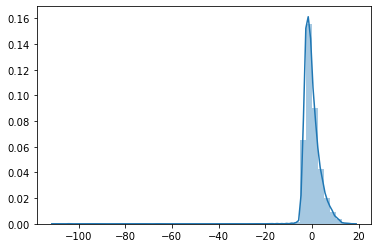

In [20]:
sns.distplot(residuals)

In [21]:
np.mean(residuals)

amount    2.546754e-13
dtype: float64

# 3 - HOMOSCADACISTY OR CONSTANT VARIANCE

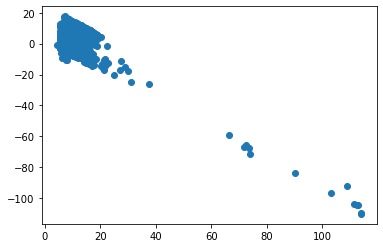

In [22]:
plt.scatter(y_predict,residuals)

# 4 - NO AUTO CORRELATION

In [23]:
import statsmodels.tsa.api as smt

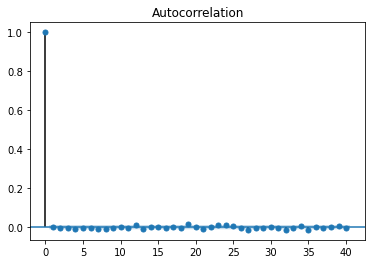

In [24]:
smt.graphics.plot_acf(residuals,lags = 40, alpha= 0.05).show()

DURBAUN WATSON STATISTIC

In [25]:
residuals['re'] = residuals['amount']

In [26]:
residuals = residuals.drop(['amount'], axis = 1)

In [27]:
residuals['re - 1'] = residuals.shift(1)
residuals = residuals.dropna()
residuals['sub'] = residuals['re'] - residuals['re - 1']
nume = np.square(residuals['sub'])
numerator = sum(nume)
denominator = sum(np.square(residuals['re']))
d = numerator/denominator

In [28]:
d

2.002912988943643